# Problem 1

# Problem 2

In [46]:
# load in fashion MNIST dataset

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

# download data
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# split data into training/test
# split training data into training/validation
# set up data loaders
train_split = int(0.8 * len(train))
val_split = len(train) - train_split
train, val = random_split(train, [train_split, val_split])
train_loader = DataLoader(train, batch_size=1, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

# labels for later
master_labels = ["T-shirt", "Pants", "Pullover" , "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

T-shirt
torch.Size([1, 1, 28, 28])


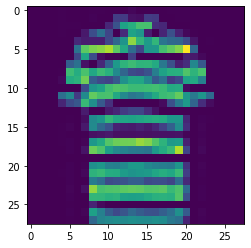

In [47]:
img, lab = next(iter(train_loader))
print(master_labels[lab])
print(img.shape)
plt.imshow(img.squeeze())

In [48]:
# build autoencoder

class FashioNet(nn.Module):
    def __init__(self):
        super(CorruptioNet, self).__init__()
        
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 16, 7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(16, 8, 5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Dropout(0.5)
        )
        
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(16, 1, 1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
            nn.Dropout(0.5)
        )
        
        self.c1 = nn.ConvTranspose2d(1, 1, 1, stride=1, padding=0)
        self.a1 = nn.Sigmoid()
        self.bn1 = nn.BatchNorm2d(1)
        self.d1 = nn.Dropout(0.5)
        
    def Decoder2(self, x, x_old):
        x = self.c1(x + x_old)
        #x = self.c1(x)
        x = self.bn1(x)
        x = self.d1(x)
        x = self.a1(x)
        x = torch.round(x * 255) # rescaling to RGB range
        return(x)
    
    def forward(self, x, lab):
        x_old = x
        x_r = x[:,0,:,:].unsqueeze(1)
        x_g = x[:,1,:,:].unsqueeze(1)
        x_b = x[:,2,:,:].unsqueeze(1)
        
        x_r = self.Encoder(x_r)
        x_g = self.Encoder(x_g)
        x_b = self.Encoder(x_b)
        
        x_r = self.Decoder(x_r)
        x_g = self.Decoder(x_g)
        x_b = self.Decoder(x_b)
        
        x_r = self.Decoder2(x_r, x_old[:,0,:,:].unsqueeze(1))
        x_g = self.Decoder2(x_g, x_old[:,1,:,:].unsqueeze(1))
        x_b = self.Decoder2(x_b, x_old[:,2,:,:].unsqueeze(1))
        
        x = torch.cat((x_r, x_g, x_b), dim=1)
        
        return x

In [49]:
# define training function

def train_model(model, train_loader, val_loader, epoch):
    start = time()
    
    # define loss function
    # set optimizer
    #criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-11, weight_decay=0)
    
    model = model.to(device)
    
    # run training loop
    losses = []
    val_losses = []
    min_loss = 0
    i = 0
    stop_flag = False
    for batch_id, (img, lab) in enumerate(train_loader):
        img = img.to(device)
        lab = lab.to(device)

        # training loss + gradient descent
        print(f"""Batch {batch_id}/{len(train_loader)}""", end="\r")
        model.train()
        optimizer.zero_grad()

        out_image = model(img, lab)
        
        loss = criterion(img, out_image)
        loss.backward()
        optimizer.step()
        losses.append([epoch, batch_id, loss.item()/N_train])

        # validation loss
        model.eval()
        val_loss = 0
        N = 0
        with torch.no_grad():
            for _, (img, lab) in enumerate(val_loader):
                lab = lab.to(device)
                img = img.to(device)

                N_batch = corr.size(0)
                N += N_batch
                
                out_image = model(img, lab)
                
                loss = criterion(img, out_image)
                
                val_loss += loss.item()
                break
        val_loss = val_loss/N
        val_losses.append([epoch, batch_id, val_loss])

        # save models periodically
        if (i % 50 == 0) & (i > 1):
            old_model = model
            
            # show test image
            losses2 = np.array(losses)
            val_losses2 = np.array(val_losses)
            fig, ax = plt.subplots(1,3,figsize=(10,5))
            ax[0].plot(losses2[:,1], losses2[:,2], marker='', label="training")
            ax[0].plot(val_losses2[:,1], val_losses2[:,2], marker='', label="validation")

            _, (img, lab) = next(enumerate(val_loader))
            out_image = model(img, lab)
            plt.imshow(out_image)
            
            # early stopping
            if i > 5:
                recent_loss = np.mean(np.array(val_losses)[-50:-1,2])
                if min_loss == 0:
                    min_loss = recent_loss
                elif recent_loss < min_loss:
                    min_loss = recent_loss
                elif recent_loss > min_loss:
                    stop_flag = True
                    return old_model, losses, val_losses, stop_flag
        
        i += 1

    print(time() - start)
    return model, losses, val_losses, stop_flag

In [50]:
# generate 10 images per class (dress, coat, sandal, sneaker)
# generate manifold plot (tips in homework)

label_embed = torch.zeros(img.shape[0], 10, img.shape[2], img.shape[3], device=img.device)
label_embed[range(img.shape[0]), lab] = 1.0  # One-hot encoding for labels

img = torch.cat((img, label_embed), dim=1)

In [51]:
img.shape

torch.Size([1, 11, 28, 28])